Dependencies

In [1]:
!pip3 install keras tensorflow-gpu cudatoolkit cudnn
!pip3 install matplotlib
!pip3 install numpy
!pip3 install pandas
!pip3 install scikit-learn
!pip3 install seaborn
!pip3 install 'tensorflow[and-cuda]'

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [39 lines of output]
      Traceback (most recent call last):
        File "/home/dariu/anaconda3/envs/gpu_env/lib/python3.10/site-packages/packaging/requirements.py", line 36, in __init__
          parsed = _parse_requirement(requirement_string)
        File "/home/dariu/anaconda3/envs/gpu_env/lib/python3.10/site-packages/packaging/_parser.py", line 62, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
        File "/home/dariu/anaconda3/envs/gpu_env/lib/python3.10/site-packages/packaging/_parser.py", line 80, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
        File "/home/dariu/anaconda3/envs/gpu_env/lib/python3.10/site-packages/packaging/_parser.py", line 124, in _parse_requir

Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet121

2025-01-11 19:33:39.567958: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736616819.678592    1607 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736616819.710438    1607 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-11 19:33:39.993390: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Data preprocessing

In [3]:
def create_data_generators(data_dir='chest_xray', img_size=(224, 224), batch_size=32):

    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        f'{data_dir}/train',
        seed=123,
        image_size=img_size,
        batch_size=batch_size,
        label_mode='binary'
    )
    
    val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        f'{data_dir}/val',
        seed=123,
        image_size=img_size,
        batch_size=batch_size,
        label_mode='binary'
    )
    
    test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        f'{data_dir}/test',
        seed=123,
        image_size=img_size,
        batch_size=batch_size,
        label_mode='binary'
    )
    
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomContrast(0.2)
    ])
    
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    
    # Apply augmentation and normalization to training data
    train_dataset = train_dataset.map(
        lambda x, y: (data_augmentation(x), y)
    ).map(
        lambda x, y: (normalization_layer(x), y)
    )
    
    # Apply only normalization to validation and test data
    val_dataset = val_dataset.map(
        lambda x, y: (normalization_layer(x), y)
    )
    test_dataset = test_dataset.map(
        lambda x, y: (normalization_layer(x), y)
    )
    
    # Configure datasets for performance
    AUTOTUNE = tf.data.AUTOTUNE
    train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
    val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
    test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
    
    return train_dataset, val_dataset, test_dataset


Model Architectures

In [4]:
def create_custom_cnn():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

def create_transfer_learning_model(base_model_name='VGG16'):

    if base_model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif base_model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif base_model_name == 'DenseNet121':
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        for layer in base_model.layers[-20:]:
            layer.trainable = True
    elif base_model_name == 'CNN':
        base_model = create_custom_cnn()
        return base_model
    if base_model_name == 'VGG16' or base_model_name == 'ResNet50' or base_model_name == 'CNN':
        model = tf.keras.Sequential([
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
    elif base_model_name == 'DenseNet121':
        model = tf.keras.Sequential([
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
    return model


Training

In [5]:
def load_saved_model(model_name):
    """Load a saved model"""
    try:
        return tf.keras.models.load_model(f'best_{model_name}.keras')
    except (OSError, IOError) as e:
        print("Model file not found, continuining with training...")
    return None

def evaluate_model(model, test_dataset):
    """Evaluate a model on test data"""
    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"\nTest accuracy: {test_accuracy:.4f}")
    print(f"Test loss: {test_loss:.4f}")
    
    return test_loss, test_accuracy

In [6]:
def train_and_evaluate(model, model_name, continue_training=False):

    tf.keras.backend.clear_session()
    with torch.no_grad():
        torch.cuda.empty_cache()

    model_path = f'best_{model_name}.h5'

    if not continue_training and os.path.exists(model_path):
        print(f"Loading existing model: {model_path}")
        model = tf.keras.models.load_model(model_path)
    else:
        print("Creating new model...")
        model = create_transfer_learning_model(model_name)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.F1Score()]
    )


    callbacks = [
        tf.keras.callbacks.EarlyStopping(
        patience=5,  # Increased patience
        restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=0.00001
        ),
        tf.keras.callbacks.ModelCheckpoint(
            f'best_{model_name}.keras',
            save_best_only=True,
            monitor='val_f1_score'
        )
    ]

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=callbacks
    )
  
    return model, history

Model Comparison

In [7]:
from tensorflow.keras import mixed_precision

def compare_models():
    models = {
        'CNN': create_custom_cnn(),
        'VGG16': create_transfer_learning_model('VGG16'),
        'ResNet50': create_transfer_learning_model('ResNet50'),
        'DenseNet121': create_transfer_learning_model('DenseNet121')
    }
    
    results = {}
    for name, model in models.items():
        print(f"Training {name}...")
        
        if name == "DenseNet121":
            policy = mixed_precision.Policy('mixed_float16')
            mixed_precision.set_global_policy(policy)

        trainedModel, history = train_and_evaluate(model, name)
        if history.history != None:
            results[name] = history.history
    
    return results



Visualization

In [8]:
def plot_results(results):
    plt.figure(figsize=(12, 8))
    for model_name, history in results.items():
        plt.plot(history['val_accuracy'], label=f'{model_name}')
    plt.title('Model Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.show()


Comparison

In [9]:
def plot_performance_comparison(metrics):
    # Bar plot for Recall and F1 Score
    plt.figure(figsize=(12, 6))
    
    models = list(metrics.keys())
    recalls = [m['recall'] for m in metrics.values()]
    f1_scores = [m['f1'] for m in metrics.values()]
    
    x = np.arange(len(models))
    width = 0.35
    
    plt.bar(x - width/2, recalls, width, label='Recall')
    plt.bar(x + width/2, f1_scores, width, label='F1 Score')
    
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x, models, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [10]:
def plot_confusion_matrices(metrics):
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    fig.suptitle('Confusion Matrices for Different Models')
    
    for (name, metric), ax in zip(metrics.items(), axes.flat):
        sns.heatmap(metric['confusion_matrix'], 
                   annot=True, 
                   fmt='d',
                   cmap='Blues',
                   ax=ax)
        ax.set_title(name)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
    
    plt.tight_layout()
    plt.show()

def create_performance_table(metrics):
    data = {
        'Model': [],
        'Recall': [],
        'F1 Score': []
    }
    
    for name, metric in metrics.items():
        data['Model'].append(name)
        data['Recall'].append(f"{metric['recall']:.4f}")
        data['F1 Score'].append(f"{metric['f1']:.4f}")
    
    return pd.DataFrame(data)

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, recall_score, f1_score

def load_and_evaluate_models(test_ds):
    metrics = {}
    
    model_names = ['ResNet50', 'VGG16', 'DenseNet121', 'CNN']
    
    for name in model_names:
        model = load_saved_model(name)
        
        y_pred = model.predict(test_ds)
        y_pred = (y_pred > 0.5).astype(int)
        
        y_true = np.concatenate([y for x, y in test_ds], axis=0)
        
        metrics[name] = {
            'recall': recall_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred),
            'confusion_matrix': confusion_matrix(y_true, y_pred)
        }

    return metrics

Main Program

In [12]:
def setup_gpu():

    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Number of TensorFlow GPUs: {len(gpus)}")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return device

Number of TensorFlow GPUs: 1
Running code on GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found 5216 files belonging to 2 classes.


I0000 00:00:1736616836.040678    1607 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:0a:00.0, compute capability: 8.6


Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


I0000 00:00:1736616842.686740    4682 service.cc:148] XLA service 0x7f9ea4049ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736616842.687180    4682 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-01-11 19:34:02.730305: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736616843.037987    4682 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-11 19:34:03.846867: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1363_0', 112 bytes spill stores, 224 bytes spill loads

2025-01-11 19:34:04.090427: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1363', 2

 1/20 ━━━━━━━━━━━━━━━━━━━━ 5:41 18s/step

I0000 00:00:1736616859.321415    4682 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 650ms/step


2025-01-11 19:34:31.880679: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-11 19:34:44.711997: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[32,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-01-11 19:34:44.775233: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.063341359s
Trying algorithm eng11{k2=1,k3=0} for conv (f32[32,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,224,224]{3

20/20 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step 


2025-01-11 19:35:51.153210: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-11 19:35:57.859401: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3275_0', 8 bytes spill stores, 8 bytes spill loads

2025-01-11 19:35:58.140260: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3275_0', 100 bytes spill stores, 100 bytes spill loads

2025-01-11 19:35:58.211430: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3275', 204 bytes spill stores, 204 bytes spill loads



20/20 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step


2025-01-11 19:37:53.100371: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


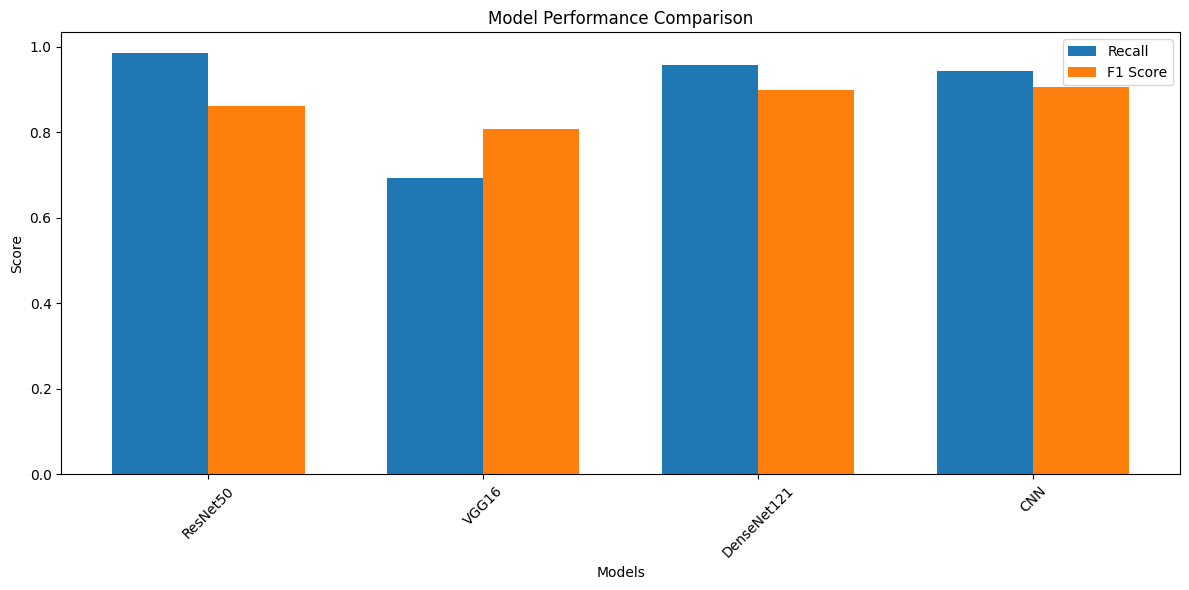

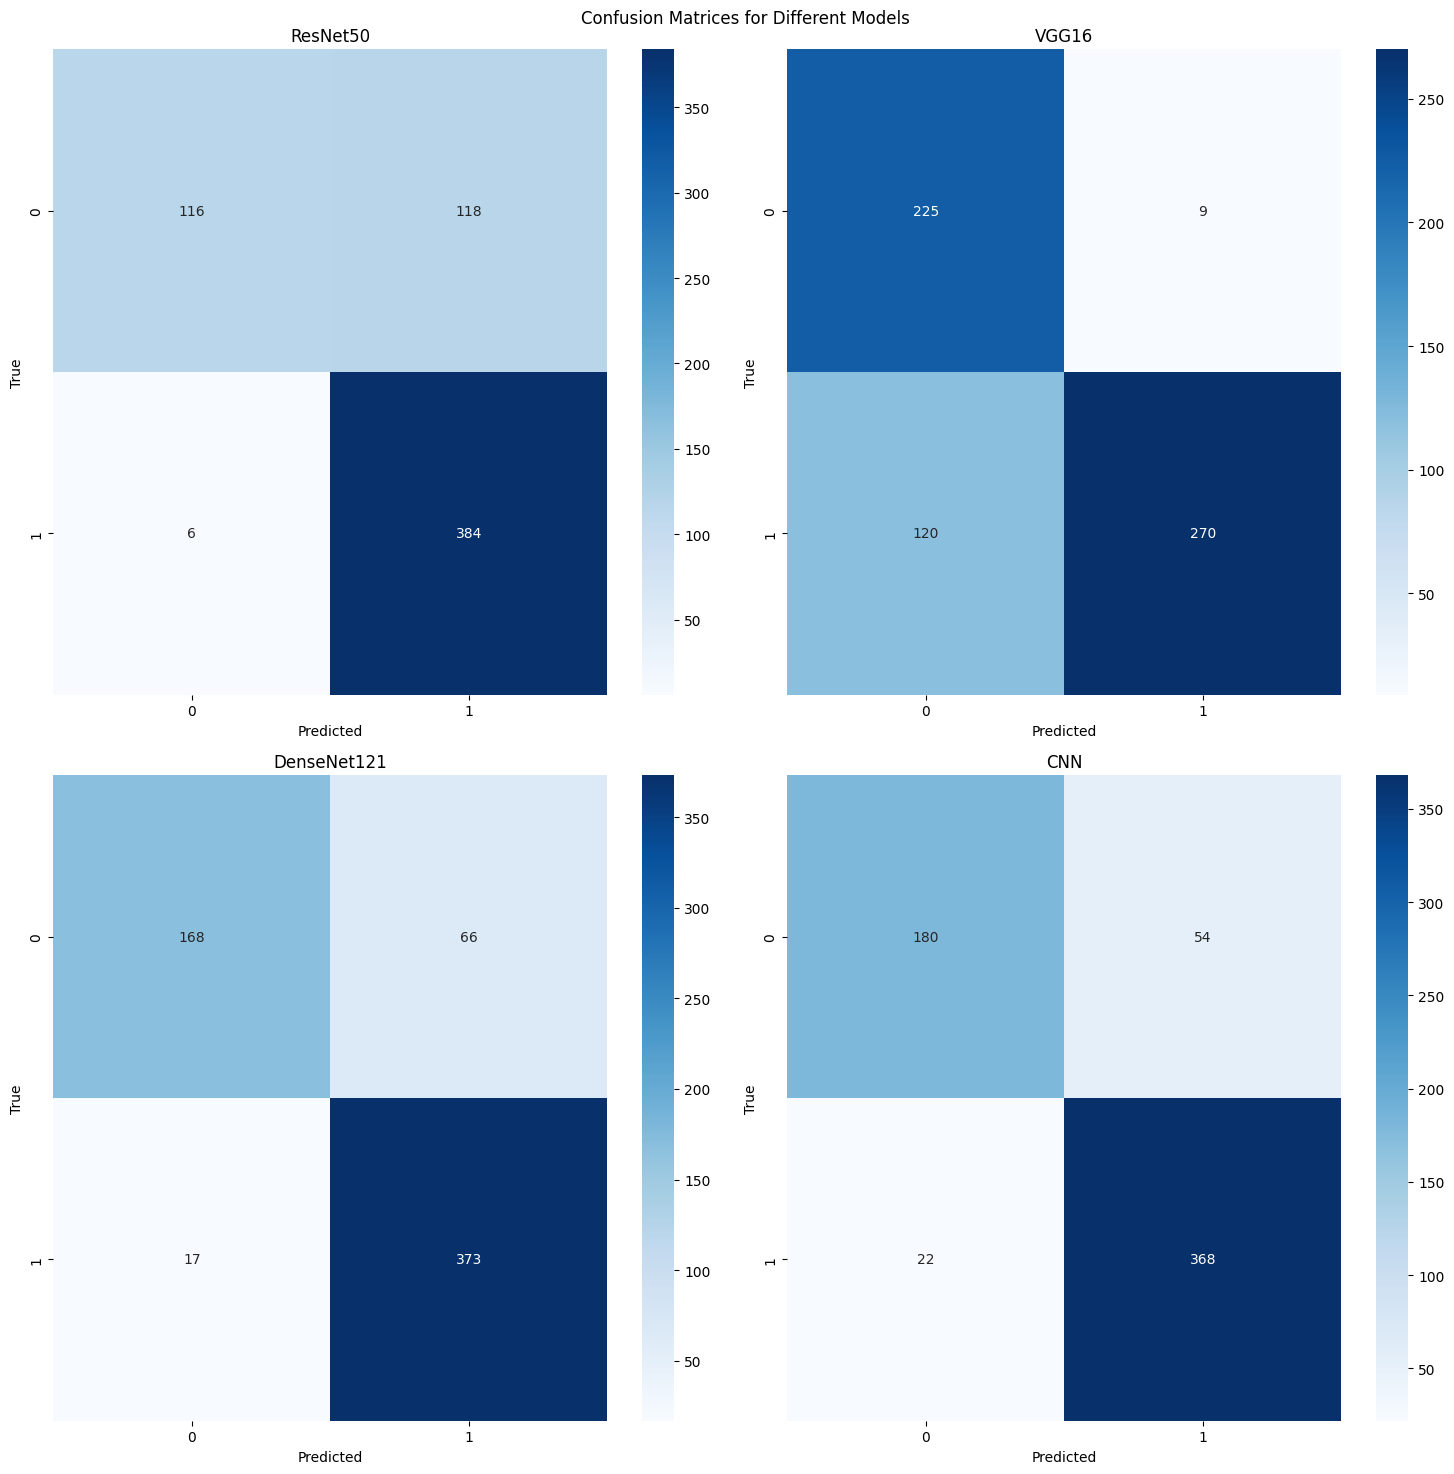


Model Performance Metrics:
         Model  Recall F1 Score
0     ResNet50  0.9846   0.8610
1        VGG16  0.6923   0.8072
2  DenseNet121  0.9564   0.8999
3          CNN  0.9436   0.9064


In [13]:
device = setup_gpu()
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Running code on GPU:", gpus)
else:
    print("Running code on CPU:", tf.config.list_physical_devices('CPU'))

train_ds, val_ds, test_ds = create_data_generators()

#results = compare_models()
#plot_results(results)
metrics = load_and_evaluate_models(test_ds)

# Create visualizations
plot_performance_comparison(metrics)
plot_confusion_matrices(metrics)

# Display performance table
performance_table = create_performance_table(metrics)
print("\nModel Performance Metrics:")
print(performance_table)


